Source: https://www.kaggle.com/code/vasilisapp/catch-me-competition

In [1]:
# Import libraries and set desired options
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

# Read

In [2]:
# read train & test sessions
times = ['time%s' % i for i in range(1, 11)]

train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id', parse_dates=times)
train_df = train_df.sort_values(by='time1')

test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id', parse_dates=times)
test_df = test_df.sort_values(by='time1')

sites = [f'site{i}' for i in range(1, 11)]

for col in sites:
    train_df[col] = train_df[col].fillna(0).astype(np.uint16)
    test_df[col] = test_df[col].fillna(0).astype(np.uint16)

In [3]:
import pickle

with open("data/site_dic.pkl","rb") as file_handle:
    sites_dict = pickle.load(file_handle)

# EDA

In [4]:
sites_df = pd.DataFrame(data=list(sites_dict.keys()), index=list(sites_dict.values()), columns=['site'])
f'Sites total: {len(sites_df)}'

'Sites total: 48371'

In [5]:
top_sites = sites_df.loc[pd.Series(train_df[sites].values.flatten()).value_counts().drop(0).index[:5]]
top_sites

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com


In [6]:
alice_sites = train_df[train_df.target==1]

In [7]:
top_alice_sites = sites_df.loc[pd.Series(alice_sites[sites].values.flatten()).value_counts().index[:15]]
top_alice_sites

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [8]:
time_df = pd.DataFrame(data=train_df.target, index=train_df.index, columns=['target'])
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

Median duration for Alice is shorter and std deviation is substantially smaller:

In [9]:
time_df[time_df['target']==1].seconds.describe()

count    2297.000000
mean       52.296474
std       153.309014
min         0.000000
25%         4.000000
50%        11.000000
75%        38.000000
max      1763.000000
Name: seconds, dtype: float64

In [10]:
time_df[time_df['target']==0].seconds.describe()

count    251264.000000
mean        139.282372
std         296.653518
min           0.000000
25%           7.000000
50%          28.000000
75%         114.000000
max        1800.000000
Name: seconds, dtype: float64

In [11]:
time_df.target.mean()

0.00905896411514389

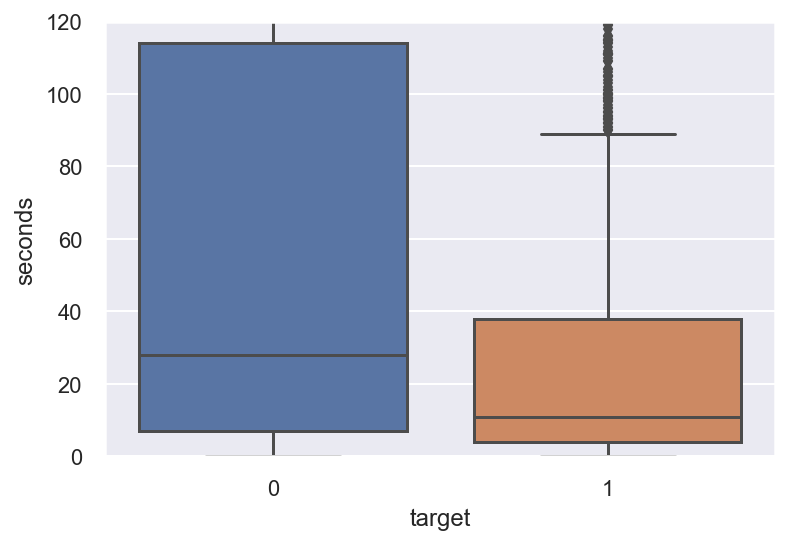

In [12]:
sns.set()
sns.boxplot(x='target', y='seconds', data=time_df)
plt.ylim(0, 120);

# Transform

In [13]:
y_train = train_df.target

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]

In [14]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [15]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

In [16]:
# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
# here's how it works: https://stackoverflow.com/questions/53254104/cant-understand-scipy-sparse-csr-matrix-example
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10)
    )
)[:, 1:]

In [17]:
full_sites_sparse.shape

(336358, 48371)

# Training

In [18]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [88]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
auc_base = get_auc_lr_valid(X_train, y_train)
print(auc_base)

0.9195245587148384
CPU times: total: 18.9 s
Wall time: 3.24 s


In [20]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

In [22]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

1. Model Improvement: Feature Engineering Now we are going to try to improve the quality of our model by adding new features to the data.

Create a feature that will be a number in YYYYMM format from the date when the session was held, for example 201407 -- year 2014 and 7th month. Thus, we will take into account the monthly linear trend for the entire period of the data provided.

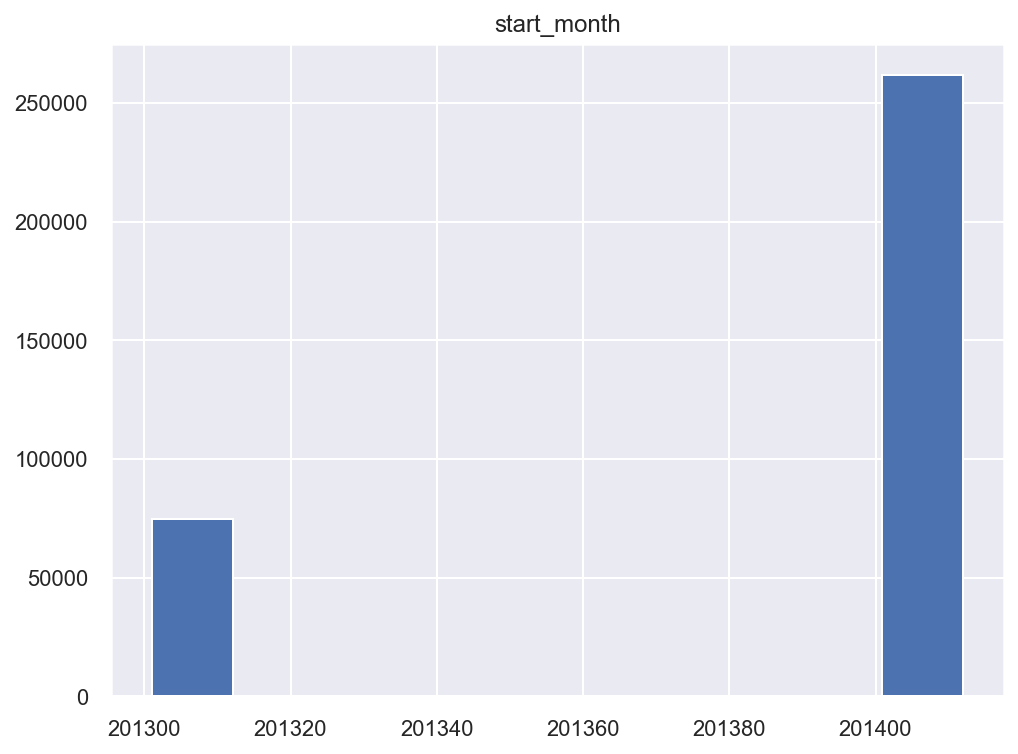

In [23]:
plt.rcParams['figure.figsize'] = (8,6);
full_new_feat.hist();

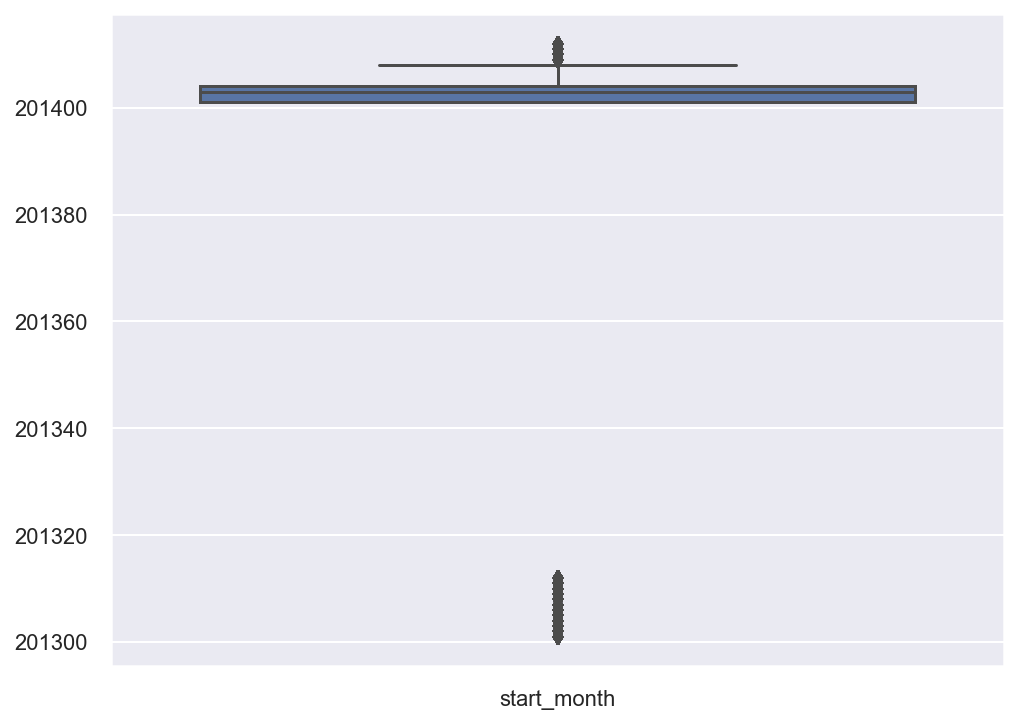

In [24]:
sns.boxplot(data = full_new_feat);

In [25]:
full_new_feat.size

336358

In [26]:
full_new_feat1 = full_new_feat[:idx_split]
full_new_feat.head()

,start_month
session_id,
21669,201301.0
54843,201301.0
77292,201301.0
114021,201301.0
146670,201301.0


In [27]:
full_new_feat.start_month.value_counts()

201403.0    56250
201402.0    55563
201401.0    35869
201311.0    34493
201404.0    31204
201405.0    25680
201312.0    16552
201412.0    12388
201407.0    10837
201411.0     9897
201410.0     8157
201408.0     7846
201406.0     4365
201304.0     3997
201302.0     3929
201409.0     3627
201309.0     3464
201303.0     3337
201305.0     3229
201310.0     2788
201306.0     2094
201301.0      363
201308.0      290
201307.0      139
Name: start_month, dtype: int64

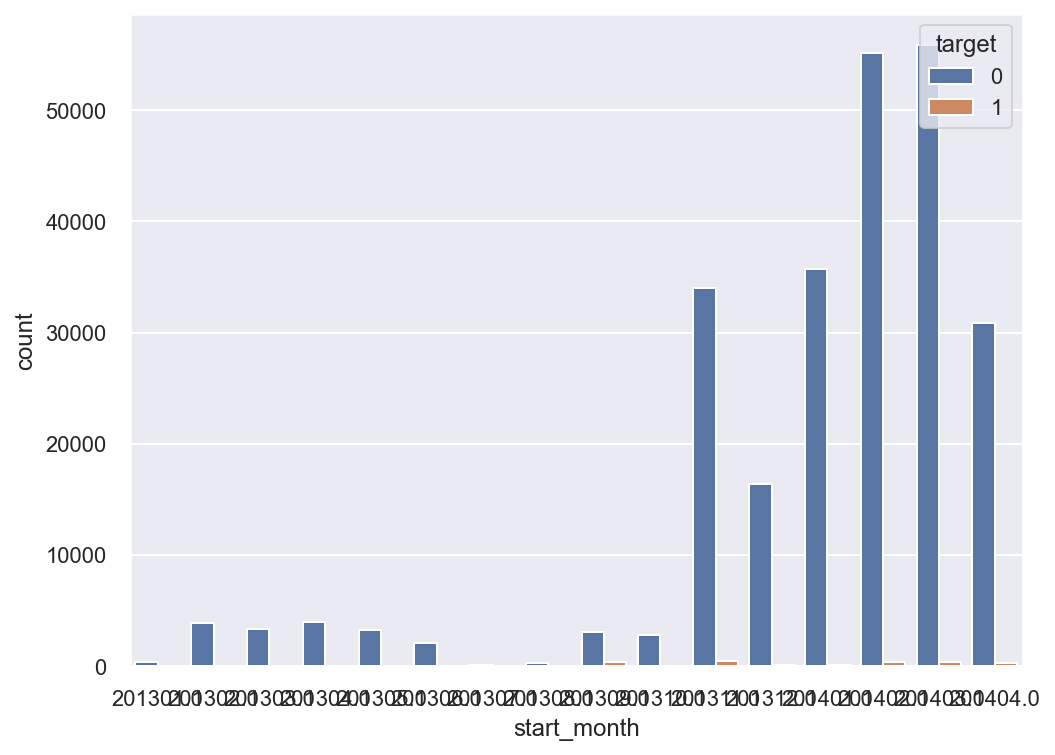

In [28]:
sns.countplot(x='start_month', hue=y_train, data=full_new_feat1);

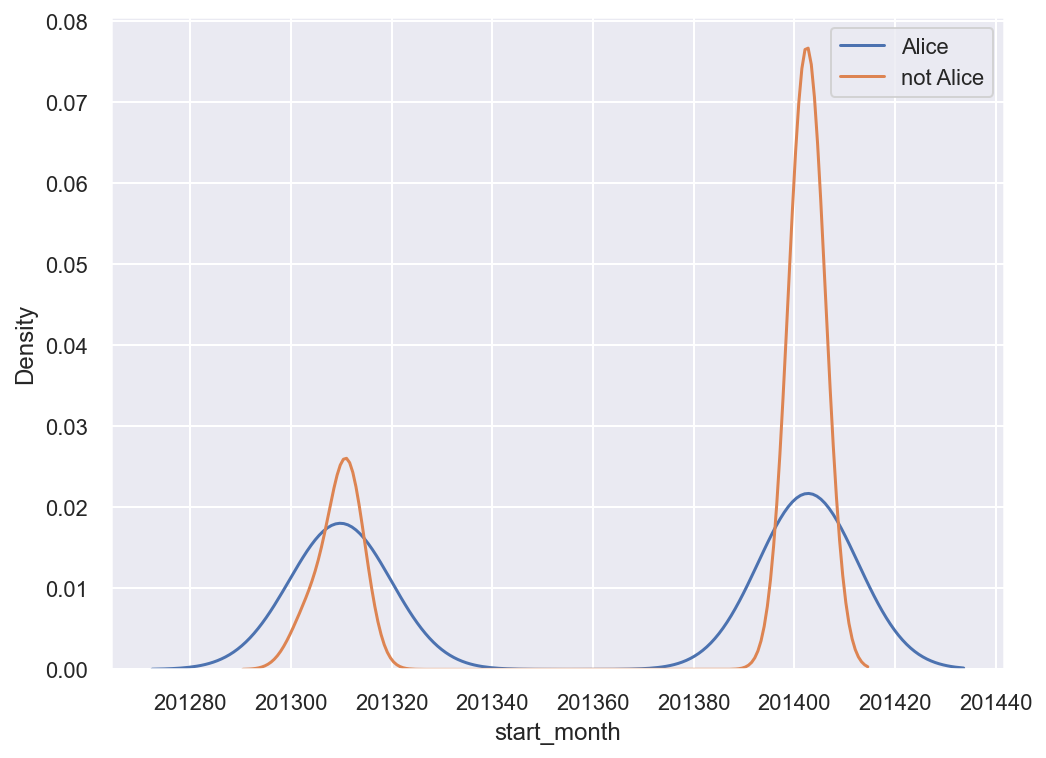

In [29]:
fig = sns.kdeplot(full_new_feat1[y_train==1]['start_month'], label='Alice')
fig = sns.kdeplot(full_new_feat1[y_train==0]['start_month'], label='not Alice')
fig.legend();

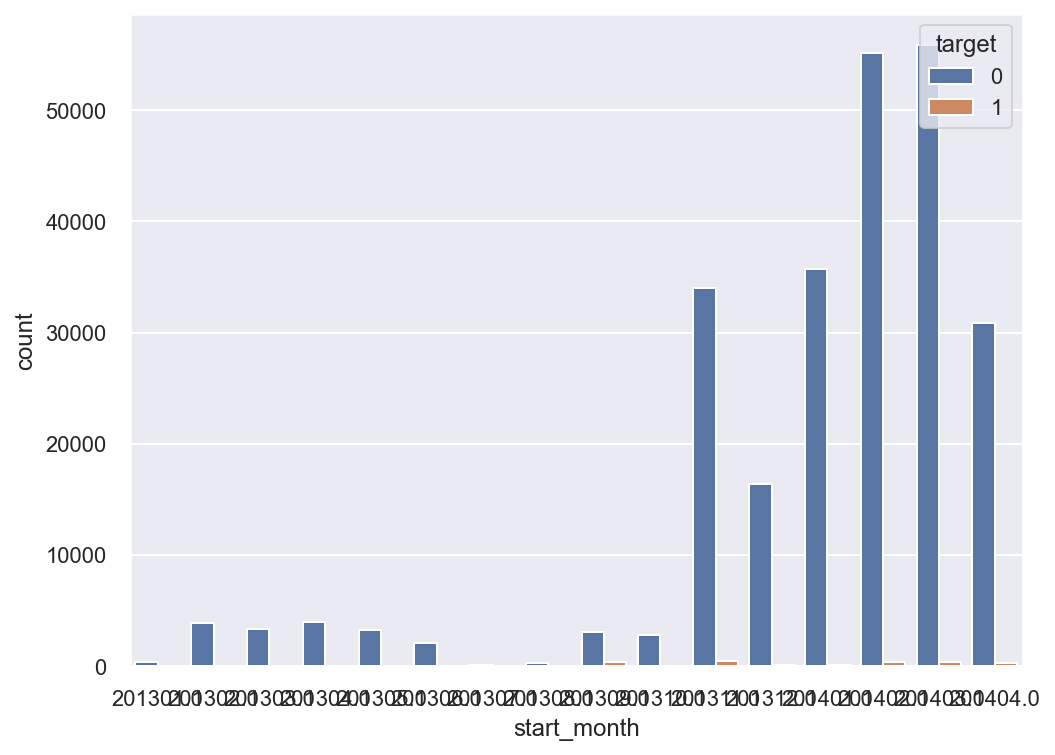

In [30]:
sns.countplot(x = full_new_feat1['start_month'], hue = y_train, data = full_new_feat1);

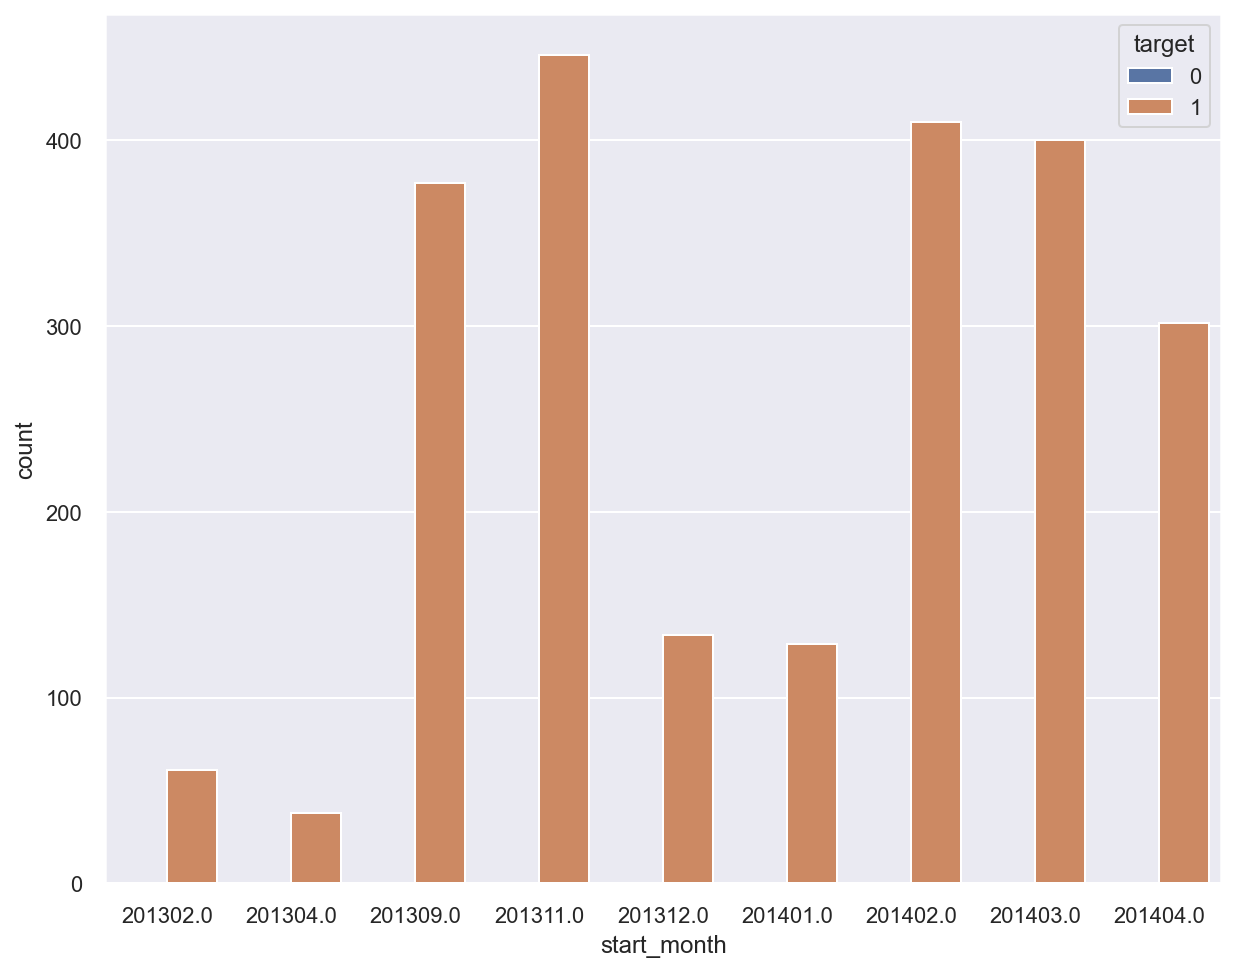

In [31]:
plt.rcParams['figure.figsize'] = (10,8);
sns.countplot(x = full_new_feat1[y_train == 1]['start_month'], hue = y_train, data = full_new_feat1);

In [32]:
full_new_feat1[y_train==1]['start_month'].value_counts()

201311.0    446
201402.0    410
201403.0    400
201309.0    377
201404.0    302
201312.0    134
201401.0    129
201302.0     61
201304.0     38
Name: start_month, dtype: int64

In [33]:
full_new_feat1[y_train==1].size

2297

In [34]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


## Scale features

In [35]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196990680356892


Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed For discussions, please stick to ODS Slack, channel #mlcourse_ai_news, pinned thread #a3_part1_fall2019

In [36]:
full_new_feat['n_unique_sites'] = full_sites.apply(pd.Series.nunique, axis=1)

In [37]:
full_new_feat.head()

,start_month,n_unique_sites
session_id,,
21669,201301.0,3
54843,201301.0,3
77292,201301.0,6
114021,201301.0,5
146670,201301.0,6


<AxesSubplot:xlabel='n_unique_sites', ylabel='count'>

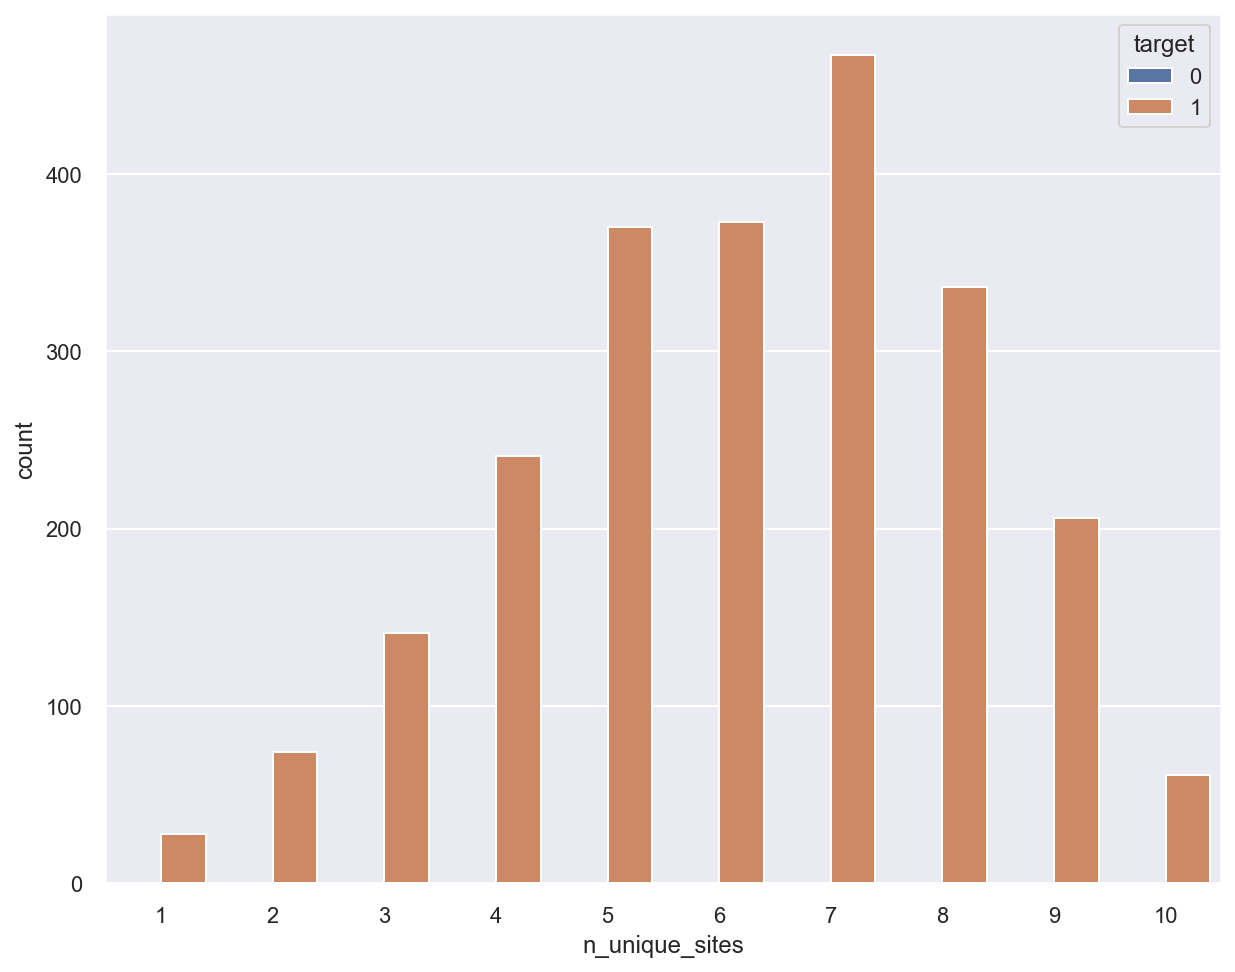

In [38]:
full_new_feat1 = full_new_feat[:idx_split]
plt.figure(figsize=(10, 8))

sns.countplot(x=full_new_feat1[y_train==1].n_unique_sites, hue=y_train, data = full_new_feat1)

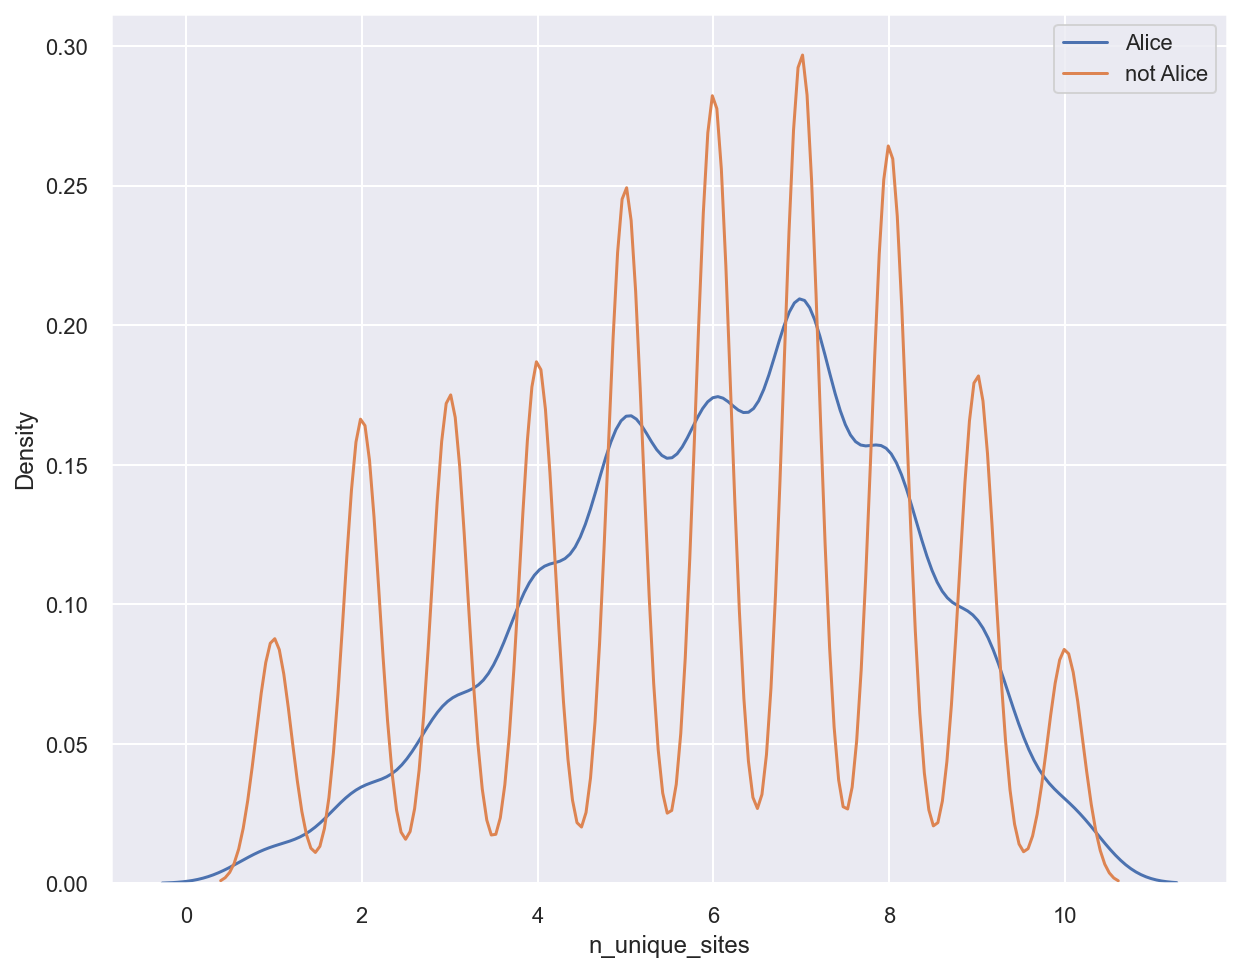

In [39]:
fig = sns.kdeplot(full_new_feat1[y_train == 1]['n_unique_sites'], label = 'Alice')
fig = sns.kdeplot(full_new_feat1[y_train == 0]['n_unique_sites'], label = 'not Alice')
plt.legend();

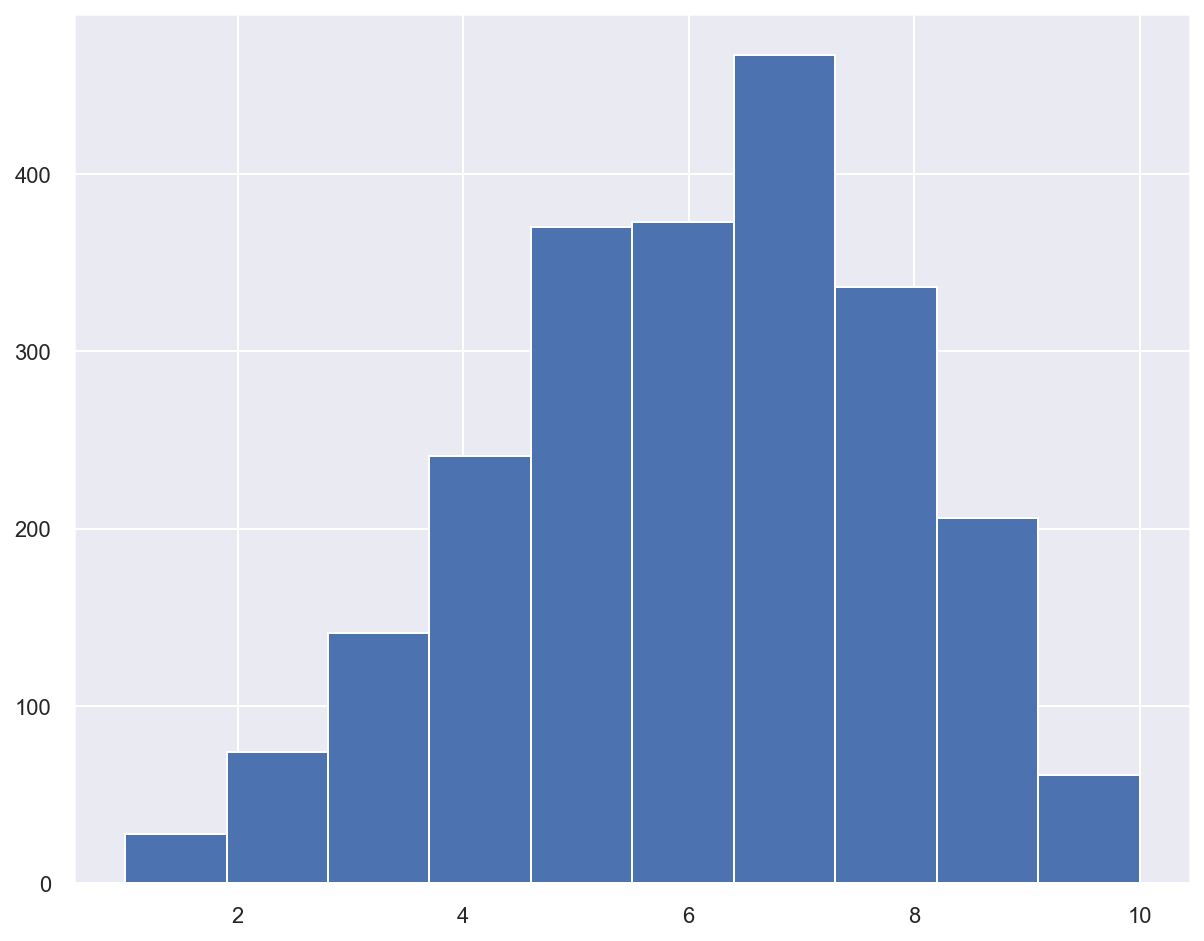

In [40]:
full_new_feat1[y_train == 1]['n_unique_sites'].hist();

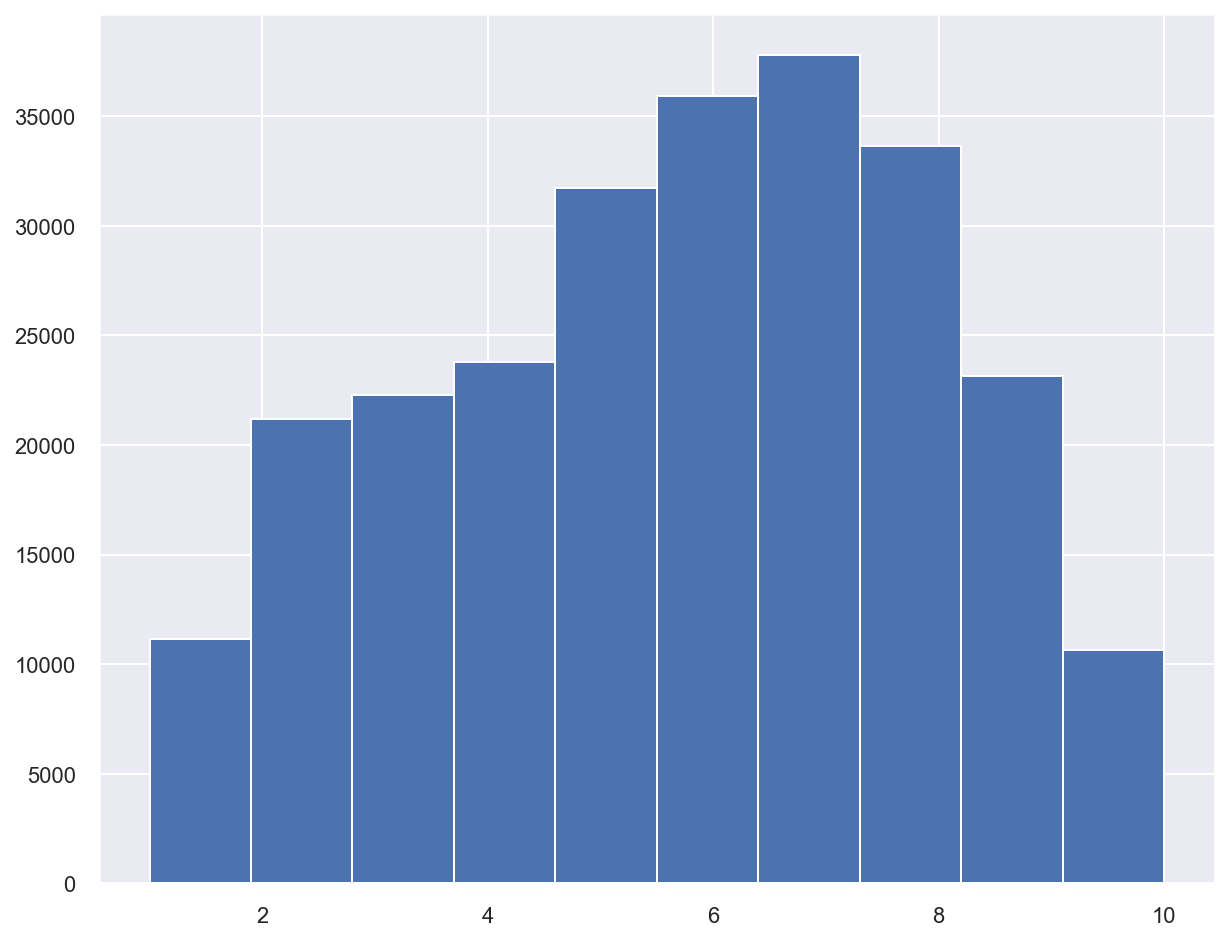

In [41]:
full_new_feat1[y_train == 0]['n_unique_sites'].hist();

In [42]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['n_unique_sites']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

get_auc_lr_valid(X_train, y_train)

0.9163707858112449

Score decreased. Do not add `n_unique_sites` feature.

## Start hour feature

In [43]:
full_new_feat['start_hour'] = full_df.time1.dt.hour

In [44]:
tmp = full_new_feat[['start_hour']].values

In [45]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

In [46]:
get_auc_lr_valid(X_train, y_train)

0.9560835066349773

Works well. I'd check CV though.

In [47]:
lr1 = LogisticRegression(max_iter=1000)

In [48]:
cv_res = cross_val_score(lr1, X_train, y_train)

In [49]:
cv_res

array([0.99018003, 0.98787269, 0.99175737, 0.99159962, 0.99063338])

In [50]:
cv_res.mean()

0.9904086205236128

CV's good. Add to final feature set.

Actually this is not good at all.

The dataset is highly unbalanced and the result is consistent with predicting all 0s.

## Morning feature

In [51]:
full_new_feat['morning'] = full_new_feat.start_hour.apply(lambda t: 1 if t <= 11 else 0)

In [52]:
tmp = full_new_feat[['morning']].values

In [53]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

In [54]:
get_auc_lr_valid(X_train, y_train)

0.9472943356327503

`morning` feature improves the score but not as much as `start_hour`. Drop it.

## Month feature

In [55]:
full_new_feat['start_month'] = full_df.time1.dt.month.values

In [56]:
tmp = full_new_feat[['start_month']].values

In [57]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

In [58]:
get_auc_lr_valid(X_train, y_train)

0.9189943885290012

No improvement here. Drop it.

## `start_hour`, `morning`, `start_month` features together, scaled

In [59]:
tmp_scaled = StandardScaler().fit_transform(
    full_new_feat[['start_hour', 'morning', 'start_month']]
)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]]))
get_auc_lr_valid(X_train, y_train)

0.958314236941389

Still not as good as `start_hour` not scaled alone.

## Optimize regularization parameter

In [73]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [74]:
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

AUC_ROC = np.zeros((10,1))

i = 0
for current_C in Cs:
    AUC_ROC[i] = get_auc_lr_valid(X_train, y_train, C = current_C)
    print('AUC_ROC', AUC_ROC[i], "current_C", current_C )
    i = i + 1 

AUC_ROC [0.82108726] current_C 0.001
AUC_ROC [0.89666806] current_C 0.0027825594022071257
AUC_ROC [0.9394156] current_C 0.007742636826811269
AUC_ROC [0.95629289] current_C 0.021544346900318832
AUC_ROC [0.9603771] current_C 0.05994842503189409
AUC_ROC [0.96074333] current_C 0.1668100537200059
AUC_ROC [0.95962336] current_C 0.46415888336127775
AUC_ROC [0.95777365] current_C 1.2915496650148828
AUC_ROC [0.95477257] current_C 3.593813663804626
AUC_ROC [0.95022265] current_C 10.0


In [83]:
b = np.argmax(AUC_ROC)
C = Cs[b]
print(f"Best regularization parameter: {C:.5f}")

Best regularization parameter: 0.16681


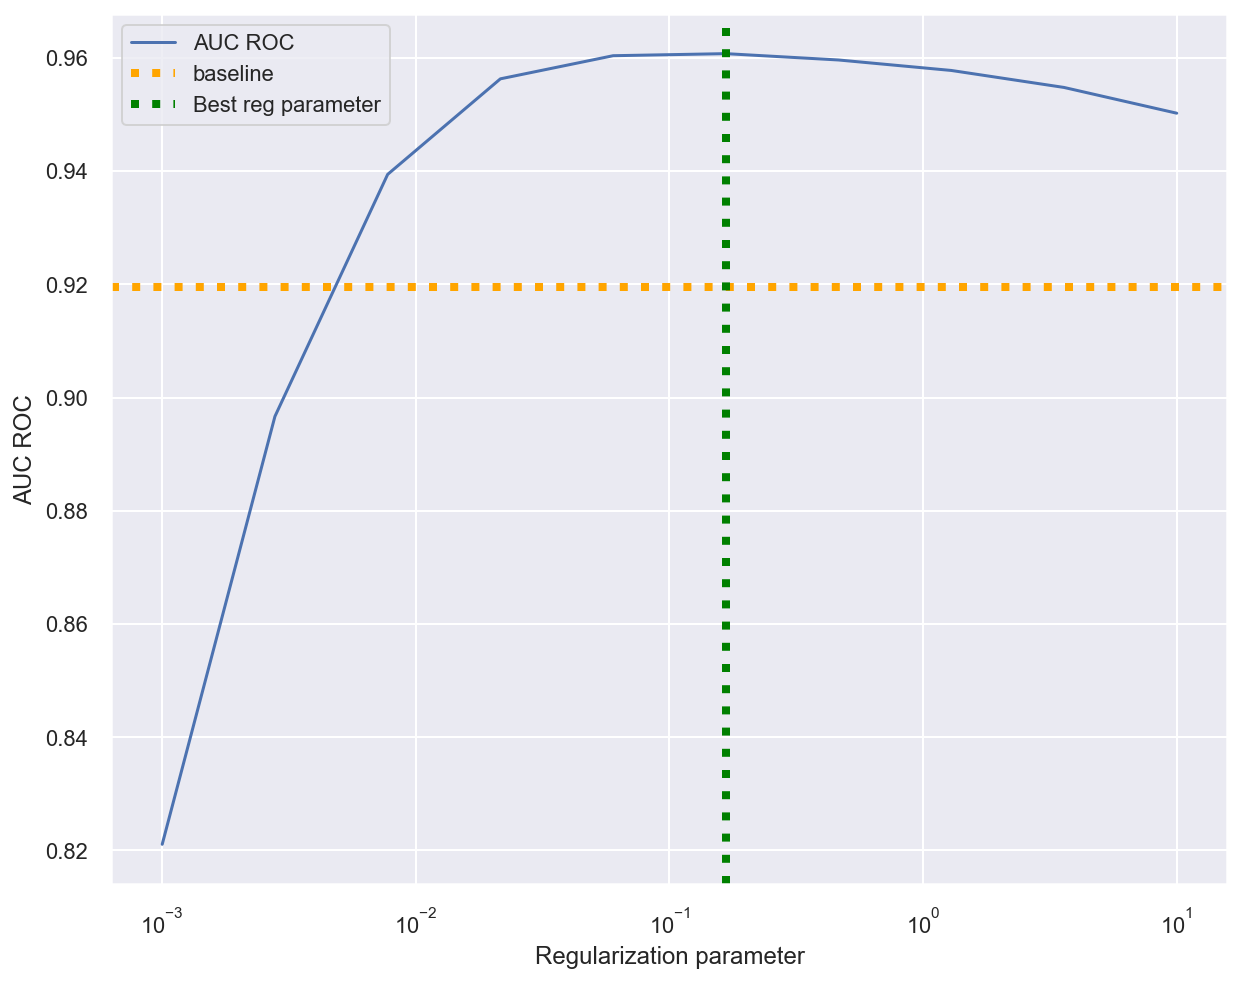

In [103]:
plt.plot(Cs, AUC_ROC, label='AUC ROC')
plt.axhline(y = auc_base, color = 'orange', linestyle = ':', linewidth = 4, label = 'baseline')
plt.axvline(x = C, color = 'green', linestyle = ':', linewidth = 4, label = 'Best reg parameter')
plt.xscale('log')
plt.legend()
plt.xlabel('Regularization parameter')
plt.ylabel('AUC ROC');

In [104]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_243434.csv')

print('ok')

ok


# My solution

Base sparse matrix + `start_hour` feature.

May be session duration as well since there is a substantial difference there.

## Start hour feature

In [128]:
full_new_feat['start_hour'] = full_df.time1.dt.hour

In [129]:
tmp = full_new_feat[['start_hour']].values

In [130]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

In [136]:
get_auc_lr_valid(X_train, y_train, seed=None)

0.9560835066349773

Works well. I'd check CV though.

In [132]:
lr1 = LogisticRegression(max_iter=1000)

In [133]:
cv_res = cross_val_score(lr1, X_train, y_train)

In [134]:
cv_res

array([0.99018003, 0.98787269, 0.99175737, 0.99159962, 0.99063338])

In [135]:
cv_res.mean()

0.9904086205236128

CV's good. Add to final feature set.

In [105]:
full_sites_sparse

<336358x48371 sparse matrix of type '<class 'numpy.intc'>'
	with 3195430 stored elements in Compressed Sparse Row format>

In [106]:
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,1,3,8,1
54843,1,3,8,1
77292,1,6,8,1
114021,1,5,8,1
146670,1,6,8,1


In [137]:
tmp = full_new_feat[['start_hour']]

In [138]:
X = csr_matrix(hstack([full_sites_sparse, tmp]))
X_train = X[:idx_split, :]
X_test = X[idx_split:, :]

In [119]:
from sklearn.model_selection import StratifiedKFold

In [120]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

In [139]:
for train_idx, test_idx in skf.split(X_train, y_train):
    lr = LogisticRegression(max_iter = 1000).fit(X_train[train_idx, :], y_train.iloc[train_idx])
    y_pred = lr.predict(X_train[test_idx, :])
    score = roc_auc_score(y_train.iloc[test_idx], y_pred)
    print(f'{score}')

0.6039299405875833
0.5997800801148802
0.6029883560426075
0.6150505240866835
0.6094144641441915


In [141]:
y_train.mean()

0.00905896411514389